### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env_2 import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# Initialising Q_dictionary and States_tracked (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [4]:
# Initialising states to be tracked
def initialise_tracking_states():
    sample_q_values = [((4,2,3),(1,2))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [6]:
Episodes = 1500
env = CabDriver()

state_size = len(env.state_space)
action_size  =len(env.action_space)


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.75
        self.learning_rate =0.01        
        self.epsilon_max = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        self.decay_rate =0.001
        #self.decay_rate =0.05
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.states_tracked = []
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(16, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16,  activation='relu'))
        
        
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,episode_no):
        
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.decay_rate*episode_no)
        if((episode_no+1) % 50 == 0):
            print("epsilon ",epsilon)
        #print("epsilon ",epsilon)
        possible_actions_index,possible_actions = env.requests(state)
        if np.random.rand() <= epsilon:
            
            # explore: choose a random action from all possible actions
            return random.choice(possible_actions)
        else:
            # choose the action with the highest q(s, a)
            #print("state is",state)
            
            state =np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            if(len(list(q_vals_possible)) == 0):
                return (0,0)
            #print( "action expoited ",env.action_space[possible_actions_index[np.argmax(q_vals_possible)]])
            return env.action_space[possible_actions_index[np.argmax(q_vals_possible)]]
            
            
            

        
        
        
        


    #def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
    #    self.memory.append(state, action, reward, next_state)
    def append_sample(self, state, action, reward, next_state,terminalState):
        action =tuple(action)
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state,terminalState))

    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_size))# write here
            update_input = np.zeros((self.batch_size,self.state_size))# write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                
                state, action, reward, next_state,terminalState = mini_batch[i]
                #print(mini_batch[i])
                #print("mmasad",env.action_space.index(action))
                update_input[i] =env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                # Write your code from here
                # 1. Predict the target from earlier model
                
            target = self.model.predict(update_input)
            #print(target[0],"target shape")
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            #print(target_qval.shape,"target_qval shape")
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                #print("i is",i,target[i])
                
                #print("i is",i,target_qval[i])
                #print("i is",i,rewards[i])
                #print("i is",i,len(rewards))
                
                #print("i is",i,[actions[i]])
                #print(target[i][i])
                #print("i is",i,target[i])
                state, action, reward, next_state,terminalState = mini_batch[i]
                possible_actions_index,possible_actions = env.requests(state)
                #print("asa" ,target[i].shape)
                #print(actions[0])
                #print("state ",state,"poss actions ",possible_actions_index)
               # print("before target ",target)
                if terminalState == True:
                    target[i][env.action_space.index(actions[i])] = rewards[i]
                    #         target[i][j] = rewards[i]
                else:
                    target[i][env.action_space.index(actions[i])] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                    
                    #print(target[i][j])
               # print("after target ",target)
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)  

    def save(self, name):
        with open(name , 'wb') as f:
            pickle.dump(name, f, pickle.HIGHEST_PROTOCOL)
    
    def save_tracking_states(self,States_track):
        for state in States_track.keys():
            print(state)
            state =np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state) 
            
            self.states_tracked.append(q_value[0][env.action_space.index((1,2))])
                
                 
        

In [8]:
agent  =DQNAgent(state_size = 36,action_size= action_size)

In [9]:
initialise_tracking_states()


In [10]:
env.action_space

[(0, 1),
 (1, 0),
 (0, 2),
 (2, 0),
 (0, 3),
 (3, 0),
 (0, 4),
 (4, 0),
 (1, 2),
 (2, 1),
 (1, 3),
 (3, 1),
 (1, 4),
 (4, 1),
 (2, 3),
 (3, 2),
 (2, 4),
 (4, 2),
 (3, 4),
 (4, 3),
 (0, 0)]

### DQN block

In [33]:
rewards_per_episode = []
for episode in range(Episodes):
    total_time= 0
    
    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    print("episode no ",episode)
    terminal_state  = False
    score = 0
    #Call the DQN agent
    actionList,stateList,randomState=  env.reset()
    state = randomState
    
    while terminal_state == False:
    
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state,episode)
        
        #print(a)
        #print("Sample state and acton choosen at start of episode ", sta te, action)
        # 2. Evaluate your reward and next state
        next_state,reward,terminal_state,total_time = env.next_state_func(state,action,Time_matrix,total_time)
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state,terminal_state)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        score += reward
        state = next_state
    rewards_per_episode.append(score)
    if ((episode+1) % 100 == 0):
        agent.save(name="model_weights1.pkl")
        #agent.save_tracking_states(States_track)
        #save_obj(States_track,'States_tracked')
    if ((episode+1) % 5 == 0):
        
        agent.save_tracking_states(States_track)
        save_obj(States_track,'States_tracked')   
        # 5. Keep a track of rewards, Q-values, loss
        
    print("reward {0}, memory_length {1}, ".format( score,len(agent.memory)))
   

episode no  0
reward -224.0, memory_length 149, 
episode no  1
reward -234.0, memory_length 289, 
episode no  2
reward -64.0, memory_length 430, 
episode no  3
reward -306.0, memory_length 568, 
episode no  4
(4, 2, 3)
reward -402.0, memory_length 713, 
episode no  5
reward -203.0, memory_length 845, 
episode no  6
reward -257.0, memory_length 999, 
episode no  7
reward -775.0, memory_length 1148, 
episode no  8
reward -3.0, memory_length 1289, 
episode no  9
(4, 2, 3)
reward -541.0, memory_length 1439, 
episode no  10
reward -251.0, memory_length 1595, 
episode no  11
reward -328.0, memory_length 1735, 
episode no  12
reward -355.0, memory_length 1873, 
episode no  13
reward -93.0, memory_length 2000, 
episode no  14
(4, 2, 3)
reward -471.0, memory_length 2000, 
episode no  15
reward -442.0, memory_length 2000, 
episode no  16
reward -141.0, memory_length 2000, 
episode no  17
reward -500.0, memory_length 2000, 
episode no  18
reward -236.0, memory_length 2000, 
episode no  19
(4, 2, 

reward -67.0, memory_length 2000, 
episode no  83
reward -288.0, memory_length 2000, 
episode no  84
(4, 2, 3)
reward -272.0, memory_length 2000, 
episode no  85
reward -79.0, memory_length 2000, 
episode no  86
reward -431.0, memory_length 2000, 
episode no  87
reward -33.0, memory_length 2000, 
episode no  88
reward -3.0, memory_length 2000, 
episode no  89
(4, 2, 3)
reward 61.0, memory_length 2000, 
episode no  90
reward -269.0, memory_length 2000, 
episode no  91
reward -287.0, memory_length 2000, 
episode no  92
reward -425.0, memory_length 2000, 
episode no  93
reward -207.0, memory_length 2000, 
episode no  94
(4, 2, 3)
reward -375.0, memory_length 2000, 
episode no  95
reward -274.0, memory_length 2000, 
episode no  96
reward -549.0, memory_length 2000, 
episode no  97
reward 51.0, memory_length 2000, 
episode no  98
reward -98.0, memory_length 2000, 
episode no  99
epsilon  0.906685280943313
epsilon  0.906685280943313
epsilon  0.906685280943313
epsilon  0.906685280943313
epsil

epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.8629534237499686
epsilon  0.862953423

epsilon  0.8213543943995963
epsilon  0.8213543943995963
epsilon  0.8213543943995963
epsilon  0.8213543943995963
(4, 2, 3)
reward 164.0, memory_length 2000, 
episode no  200
reward 54.0, memory_length 2000, 
episode no  201
reward -90.0, memory_length 2000, 
episode no  202
reward 283.0, memory_length 2000, 
episode no  203
reward 138.0, memory_length 2000, 
episode no  204
(4, 2, 3)
reward 263.0, memory_length 2000, 
episode no  205
reward -130.0, memory_length 2000, 
episode no  206
reward -168.0, memory_length 2000, 
episode no  207
reward -183.0, memory_length 2000, 
episode no  208
reward 256.0, memory_length 2000, 
episode no  209
(4, 2, 3)
reward 347.0, memory_length 2000, 
episode no  210
reward 50.0, memory_length 2000, 
episode no  211
reward -6.0, memory_length 2000, 
episode no  212
reward 13.0, memory_length 2000, 
episode no  213
reward 200.0, memory_length 2000, 
episode no  214
(4, 2, 3)
reward -156.0, memory_length 2000, 
episode no  215
reward 151.0, memory_length 2000

(4, 2, 3)
reward 315.0, memory_length 2000, 
episode no  280
reward -31.0, memory_length 2000, 
episode no  281
reward 70.0, memory_length 2000, 
episode no  282
reward 277.0, memory_length 2000, 
episode no  283
reward 263.0, memory_length 2000, 
episode no  284
(4, 2, 3)
reward 501.0, memory_length 2000, 
episode no  285
reward -103.0, memory_length 2000, 
episode no  286
reward 101.0, memory_length 2000, 
episode no  287
reward 98.0, memory_length 2000, 
episode no  288
reward 27.0, memory_length 2000, 
episode no  289
(4, 2, 3)
reward 155.0, memory_length 2000, 
episode no  290
reward 441.0, memory_length 2000, 
episode no  291
reward 141.0, memory_length 2000, 
episode no  292
reward 329.0, memory_length 2000, 
episode no  293
reward 94.0, memory_length 2000, 
episode no  294
(4, 2, 3)
reward 171.0, memory_length 2000, 
episode no  295
reward -9.0, memory_length 2000, 
episode no  296
reward 8.0, memory_length 2000, 
episode no  297
reward 246.0, memory_length 2000, 
episode no  2

epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.7083391989672547
epsilon  0.708339198

epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
epsilon  0.6742807943399114
(4, 2, 3)
reward 519.0, memory_length 2000, 
episode no  400
reward -182.0, memory_length 2000, 
episode no  401
reward 106.0, memory_length 2000, 
episode no  402
reward 359.0, memory_length 2000, 
episode no  403
reward 437.0, memory_length 2000, 
episode no  404
(4, 2, 3)
reward 162.0, memory_length 2000, 
episode no  405
reward 354.0, memory_length 2000, 
episode no  406
reward 265.0, memory_length 2000, 

reward 574.0, memory_length 2000, 
episode no  478
reward 534.0, memory_length 2000, 
episode no  479
(4, 2, 3)
reward 335.0, memory_length 2000, 
episode no  480
reward 371.0, memory_length 2000, 
episode no  481
reward 436.0, memory_length 2000, 
episode no  482
reward 456.0, memory_length 2000, 
episode no  483
reward 371.0, memory_length 2000, 
episode no  484
(4, 2, 3)
reward 265.0, memory_length 2000, 
episode no  485
reward 303.0, memory_length 2000, 
episode no  486
reward 244.0, memory_length 2000, 
episode no  487
reward 575.0, memory_length 2000, 
episode no  488
reward 382.0, memory_length 2000, 
episode no  489
(4, 2, 3)
reward 691.0, memory_length 2000, 
episode no  490
reward 439.0, memory_length 2000, 
episode no  491
reward 488.0, memory_length 2000, 
episode no  492
reward 458.0, memory_length 2000, 
episode no  493
reward 543.0, memory_length 2000, 
episode no  494
(4, 2, 3)
reward 624.0, memory_length 2000, 
episode no  495
reward 407.0, memory_length 2000, 
episode

epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.5817517782743352
epsilon  0.581751778

epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
epsilon  0.5538671150051557
(4, 2, 3)
reward 588.0, memory_length 2000, 
episode no  600
reward 952.0, memory_length 2000, 
episode no  601
reward 344.0, memory_length 2000, 
episode no  602
reward 579.0, memory_length 2000, 
episode no  603
reward 549.0, memory_length 2000, 
episode no  604
(4, 2, 3)
reward 794.0, memory_length 2000, 
episode no  605
reward 548.0, memory_length 2000, 
episode no  606
reward 592.0, memory_length 2000, 
episode no  607
reward 774.0, memory_length 2000, 
episode no  608
reward 604.0, memory_length 2000, 
episode no  609
(4, 2, 3)
reward 552.0, memory_length 2000, 
episode no  610
reward 454.0, memory_length 2000, 
episode no  611
reward 594.0, memory_length 2000, 
episode no  612

reward 516.0, memory_length 2000, 
episode no  688
reward 961.0, memory_length 2000, 
episode no  689
(4, 2, 3)
reward 630.0, memory_length 2000, 
episode no  690
reward 893.0, memory_length 2000, 
episode no  691
reward 593.0, memory_length 2000, 
episode no  692
reward 803.0, memory_length 2000, 
episode no  693
reward 771.0, memory_length 2000, 
episode no  694
(4, 2, 3)
reward 314.0, memory_length 2000, 
episode no  695
reward 373.0, memory_length 2000, 
episode no  696
reward 592.0, memory_length 2000, 
episode no  697
reward 847.0, memory_length 2000, 
episode no  698
reward 742.0, memory_length 2000, 
episode no  699
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsilon  0.5021113160959313
epsi

epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.47811076400022173
epsilon  0.478

reward 728.0, memory_length 2000, 
episode no  817
reward 532.0, memory_length 2000, 
episode no  818
reward 620.0, memory_length 2000, 
episode no  819
(4, 2, 3)
reward 943.0, memory_length 2000, 
episode no  820
reward 901.0, memory_length 2000, 
episode no  821
reward 507.0, memory_length 2000, 
episode no  822
reward 460.0, memory_length 2000, 
episode no  823
reward 694.0, memory_length 2000, 
episode no  824
(4, 2, 3)
reward 908.0, memory_length 2000, 
episode no  825
reward 904.0, memory_length 2000, 
episode no  826
reward 780.0, memory_length 2000, 
episode no  827
reward 627.0, memory_length 2000, 
episode no  828
reward 401.0, memory_length 2000, 
episode no  829
(4, 2, 3)
reward 532.0, memory_length 2000, 
episode no  830
reward 623.0, memory_length 2000, 
episode no  831
reward 724.0, memory_length 2000, 
episode no  832
reward 754.0, memory_length 2000, 
episode no  833
reward 622.0, memory_length 2000, 
episode no  834
(4, 2, 3)
reward 870.0, memory_length 2000, 
episode

epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.4129066684254187
epsilon  0.412906668

epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.39325667833381095
epsilon  0.393

reward 835.0, memory_length 2000, 
episode no  1022
reward 725.0, memory_length 2000, 
episode no  1023
reward 969.0, memory_length 2000, 
episode no  1024
(4, 2, 3)
reward 831.0, memory_length 2000, 
episode no  1025
reward 821.0, memory_length 2000, 
episode no  1026
reward 968.0, memory_length 2000, 
episode no  1027
reward 907.0, memory_length 2000, 
episode no  1028
reward 757.0, memory_length 2000, 
episode no  1029
(4, 2, 3)
reward 771.0, memory_length 2000, 
episode no  1030
reward 943.0, memory_length 2000, 
episode no  1031
reward 992.0, memory_length 2000, 
episode no  1032
reward 872.0, memory_length 2000, 
episode no  1033
reward 1012.0, memory_length 2000, 
episode no  1034
(4, 2, 3)
reward 1014.0, memory_length 2000, 
episode no  1035
reward 1008.0, memory_length 2000, 
episode no  1036
reward 725.0, memory_length 2000, 
episode no  1037
reward 919.0, memory_length 2000, 
episode no  1038
reward 938.0, memory_length 2000, 
episode no  1039
(4, 2, 3)
reward 827.0, memory_

epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.33987208006008374
epsilon  0.339

epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
epsilon  0.32378402887440694
(4, 2, 3)
reward 742.0, memory_length 2000, 
episode no  1150
reward 1113.0, memory_length 2000, 
episode no  1151
reward 1155.0, memory_length 2000, 
episode no  1152
reward 626.0, memory_length 2000, 
episode no  1153
reward 1372.0, memory_length 2000, 
episode no  1154
(4, 2, 3)
reward 867.0, memory_length 2000, 
episode no  1155
reward 1183.0, memory_length 2000, 
episode no  1156
reward 967.0, memory_length 2000

(4, 2, 3)
reward 968.0, memory_length 2000, 
episode no  1230
reward 795.0, memory_length 2000, 
episode no  1231
reward 776.0, memory_length 2000, 
episode no  1232
reward 1192.0, memory_length 2000, 
episode no  1233
reward 1003.0, memory_length 2000, 
episode no  1234
(4, 2, 3)
reward 1136.0, memory_length 2000, 
episode no  1235
reward 1100.0, memory_length 2000, 
episode no  1236
reward 953.0, memory_length 2000, 
episode no  1237
reward 1003.0, memory_length 2000, 
episode no  1238
reward 1102.0, memory_length 2000, 
episode no  1239
(4, 2, 3)
reward 1138.0, memory_length 2000, 
episode no  1240
reward 893.0, memory_length 2000, 
episode no  1241
reward 1068.0, memory_length 2000, 
episode no  1242
reward 1148.0, memory_length 2000, 
episode no  1243
reward 1104.0, memory_length 2000, 
episode no  1244
(4, 2, 3)
reward 1243.0, memory_length 2000, 
episode no  1245
reward 1017.0, memory_length 2000, 
episode no  1246
reward 1307.0, memory_length 2000, 
episode no  1247
reward 1246

epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.2800764165269927
epsilon  0.280076416

reward 1111.0, memory_length 2000, 
episode no  1359
(4, 2, 3)
reward 1245.0, memory_length 2000, 
episode no  1360
reward 1067.0, memory_length 2000, 
episode no  1361
reward 811.0, memory_length 2000, 
episode no  1362
reward 1401.0, memory_length 2000, 
episode no  1363
reward 983.0, memory_length 2000, 
episode no  1364
(4, 2, 3)
reward 931.0, memory_length 2000, 
episode no  1365
reward 986.0, memory_length 2000, 
episode no  1366
reward 783.0, memory_length 2000, 
episode no  1367
reward 1107.0, memory_length 2000, 
episode no  1368
reward 878.0, memory_length 2000, 
episode no  1369
(4, 2, 3)
reward 1116.0, memory_length 2000, 
episode no  1370
reward 1238.0, memory_length 2000, 
episode no  1371
reward 1202.0, memory_length 2000, 
episode no  1372
reward 1418.0, memory_length 2000, 
episode no  1373
reward 650.0, memory_length 2000, 
episode no  1374
(4, 2, 3)
reward 1071.0, memory_length 2000, 
episode no  1375
reward 905.0, memory_length 2000, 
episode no  1376
reward 819.0, 

reward 920.0, memory_length 2000, 
episode no  1448
reward 1443.0, memory_length 2000, 
episode no  1449
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907892
epsilon  0.24245692594907

epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.23111986789174743
epsilon  0.231

reward 1138.0, memory_length 2000, 
episode no  1562
reward 1162.0, memory_length 2000, 
episode no  1563
reward 1068.0, memory_length 2000, 
episode no  1564
(4, 2, 3)
reward 1007.0, memory_length 2000, 
episode no  1565
reward 1069.0, memory_length 2000, 
episode no  1566
reward 1263.0, memory_length 2000, 
episode no  1567
reward 1015.0, memory_length 2000, 
episode no  1568
reward 1020.0, memory_length 2000, 
episode no  1569
(4, 2, 3)
reward 1136.0, memory_length 2000, 
episode no  1570
reward 841.0, memory_length 2000, 
episode no  1571
reward 1250.0, memory_length 2000, 
episode no  1572
reward 1226.0, memory_length 2000, 
episode no  1573
reward 1306.0, memory_length 2000, 
episode no  1574
(4, 2, 3)
reward 1288.0, memory_length 2000, 
episode no  1575
reward 1079.0, memory_length 2000, 
episode no  1576
reward 1185.0, memory_length 2000, 
episode no  1577
reward 1240.0, memory_length 2000, 
episode no  1578
reward 1260.0, memory_length 2000, 
episode no  1579
(4, 2, 3)
reward 

epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.20031963404048206
epsilon  0.200

epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
epsilon  0.19103763595951423
(4, 2, 3)
reward 1174.0, memory_length 2000, 
episode no  1700
reward 1037.0, memory_length 2000, 
episode no  1701
reward 1510.0, memory_length 2000, 
episode no  1702
reward 1465.0, memory_length 2000, 
episode no  1703
reward 1060.0, memory_length 2000, 
episode no  1704
(4, 2, 3)
reward 1358.0, memory_length 2000, 
episode no  1705
reward 1184.0, memory_length 2000, 
episode no  1706


reward 1340.0, memory_length 2000, 
episode no  1782
reward 1499.0, memory_length 2000, 
episode no  1783
reward 1491.0, memory_length 2000, 
episode no  1784
(4, 2, 3)
reward 1249.0, memory_length 2000, 
episode no  1785
reward 882.0, memory_length 2000, 
episode no  1786
reward 1369.0, memory_length 2000, 
episode no  1787
reward 1298.0, memory_length 2000, 
episode no  1788
reward 1154.0, memory_length 2000, 
episode no  1789
(4, 2, 3)
reward 1296.0, memory_length 2000, 
episode no  1790
reward 1006.0, memory_length 2000, 
episode no  1791
reward 1062.0, memory_length 2000, 
episode no  1792
reward 1591.0, memory_length 2000, 
episode no  1793
reward 931.0, memory_length 2000, 
episode no  1794
(4, 2, 3)
reward 1294.0, memory_length 2000, 
episode no  1795
reward 1352.0, memory_length 2000, 
episode no  1796
reward 1219.0, memory_length 2000, 
episode no  1797
reward 1370.0, memory_length 2000, 
episode no  1798
reward 1132.0, memory_length 2000, 
episode no  1799
epsilon  0.1738096

epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.16582053730348978
epsilon  0.165

KeyboardInterrupt: 

In [40]:
save_obj(agent.states_tracked,'States_tracked') 
agent.states_tracked

[82.63729,
 56.319305,
 77.54468,
 70.18712,
 87.34896,
 84.562546,
 82.87367,
 103.65503,
 85.04546,
 94.981155,
 107.75982,
 109.29169,
 95.29329,
 103.443924,
 90.428986,
 105.40708,
 92.017,
 90.05239,
 102.22427,
 80.76158,
 74.027466,
 99.89088,
 96.86077,
 107.26672,
 104.49223,
 94.49321,
 91.035286,
 95.864685,
 109.24067,
 104.243164,
 103.97028,
 89.44881,
 87.00601,
 80.815094,
 106.60155,
 96.70289,
 106.93522,
 120.34182,
 122.07365,
 115.80287,
 94.70037,
 102.99672,
 97.13621,
 118.155495,
 107.90423,
 114.086296,
 92.59953,
 110.258286,
 109.141815,
 110.60317,
 107.389,
 113.11159,
 102.90634,
 108.04329,
 104.44767,
 99.66593,
 88.9206,
 95.63366,
 93.76926,
 85.10729,
 109.12478,
 107.75181,
 100.443535,
 109.29918,
 95.35185,
 103.82961,
 102.98582,
 98.83049,
 101.25423,
 92.80356,
 109.147545,
 91.60849,
 84.53013,
 90.511826,
 100.30308,
 80.93432,
 119.420746,
 121.63559,
 111.60615,
 98.78741,
 111.1109,
 109.821754,
 105.61531,
 115.77024,
 101.44214,
 106.81

### Tracking Convergence

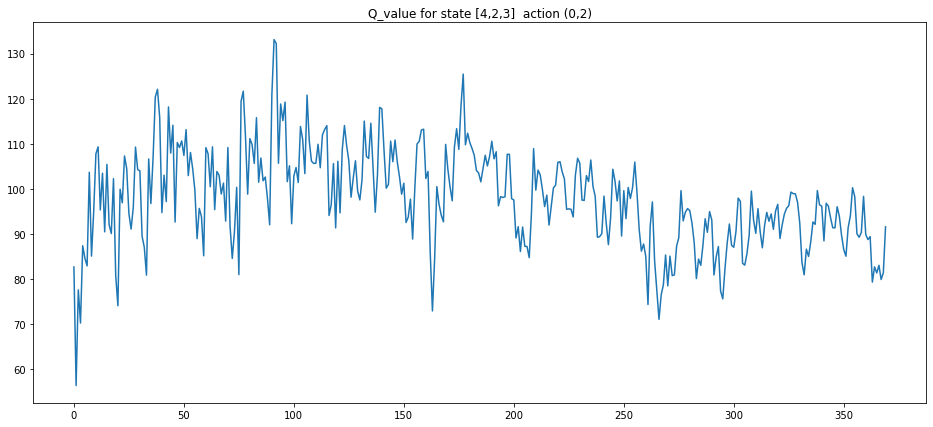

In [13]:
import pickle
agent.states_tracked = pickle.load(open("States_tracked.pkl","rb"))
plt.figure(0, figsize=(16,7))
time = np.arange(0,len(agent.states_tracked))
plt.title('Q_value for state [4,2,3]  action (0,2)')

plt.plot(time, agent.states_tracked)
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [27]:
time = np.arange(0,1500)
epsilon = []
for i in range(0,1500):
    epsilon.append(1 + (1 - 0.01) * np.exp(-0.001*i))

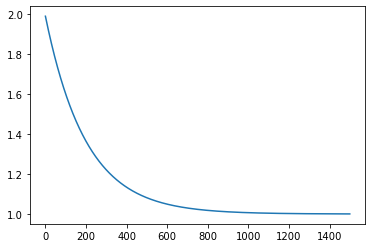

In [28]:
plt.plot(time, epsilon)
plt.show()

398

In [55]:
rewards_per_episode[:20]

[-534.0,
 -387.0,
 -53.0,
 -611.0,
 -604.0,
 -238.0,
 -518.0,
 -333.0,
 -187.0,
 -380.0,
 -259.0,
 -301.0,
 -458.0,
 -600.0,
 -119.0,
 -789.0,
 -657.0,
 -333.0,
 -200.0,
 -292.0]

In [13]:
aa = env.state_encod_arch1((1, 1, 3))
aa = aa.reshape(36)
aa.shape

(36,)

In [ ]:
update_output = np.zeros((32,self.state_size))